In [1]:
%load_ext lab_black

In [2]:
# Loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import preprocessing
from dateutil import parser
from collections import defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import spacy
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import random
import unidecode
import emoji
import json
from pprint import pprint
import gc
from datetime import datetime
from datetime import timedelta
import os
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [3]:
%matplotlib inline

# sp = spacy.load("it_core_news_lg")

### Load Input Data

In [4]:
TYPE_PAGE_LIST = ["politicians"]
TYPE_SOCIAL_LIST = ["facebook"]  # ["facebook", "instagram"]
COUNTRY_PAGE_LIST = ["italy"]

DATA_PATH = "data/"
OUTPUT_PATH = "output/"

COLUMNS_TYPES_FB = {}
COLUMNS_TYPES_IG = {}

In [5]:
MONTHS_2019 = {"dec": 12}
MONTHS_2020 = {
    "jan": 1,
    "feb": 2,
    "mar": 3,
    "apr": 4,
    "may": 5,
    "jun": 6,
    "jul": 7,
    "aug": 8,
}
df_map = {}
df_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_specific_party_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_pol_party_frequency_migration_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_pol_party_frequency_risk_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
df_pol_party_top_risk_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
lists_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
top_posts_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
risk_lists_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
risk_top_lists_months_map = {
    "dec": {},
    "jan": {},
    "feb": {},
    "mar": {},
    "apr": {},
    "may": {},
    "jun": {},
    "jul": {},
    "aug": {},
}
figures = {
    "dec": [],
    "jan": [],
    "feb": [],
    "mar": [],
    "apr": [],
    "may": [],
    "jun": [],
    "jul": [],
    "aug": [],
}
risk_figures = {
    "dec": [],
    "jan": [],
    "feb": [],
    "mar": [],
    "apr": [],
    "may": [],
    "jun": [],
    "jul": [],
    "aug": [],
}
risk_top_figures = {
    "dec": [],
    "jan": [],
    "feb": [],
    "mar": [],
    "apr": [],
    "may": [],
    "jun": [],
    "jul": [],
    "aug": [],
}
date_map = {}
post_id_range_map = {}

In [6]:
df_time_series = pd.read_csv(
    "data/basic_historical.csv", header=0, parse_dates=["date"]
)

In [7]:
def compute_engagement(row):
    followers = row["likes_at_posting"]
    interactions = (
        row["likeCount"]
        + row["commentCount"]
        + row["shareCount"]
        + row["loveCount"]
        + row["wowCount"]
        + row["hahaCount"]
        + row["sadCount"]
        + row["angryCount"]
        + row["careCount"]
        + row["thankfulCount"]
    )
    # print(row)
    # print(followers)
    # print(interactions)
    engagement = (interactions / followers) * 100
    # mean_engagement = sum(engagements) / len(engagements)
    # mean_interactions = sum(interactions_list) / len(interactions_list)
    return engagement

In [8]:
def print_things(df, by):
    group_by = by
    groups = df.groupby([group_by])
    print("Number of groups (divided by {}): {}".format(group_by, len(groups)))
    for i, g in enumerate(groups):
        name = g[0]
        df = g[1]
        if i == 0:
            print("Name: {}".format(name))
            print("Df Head:")
            print(df.head())
            print("Number of rows: {}".format(len(df)))

In [9]:
def clean_date(row):
    s_date = str(row["date"])
    new_date = s_date.split(" ")[0]
    new_date = datetime.strptime(new_date, "%Y-%m-%d")
    return new_date

In [10]:
df_time_series["engagement"] = df_time_series.apply(
    lambda row: compute_engagement(row), axis=1
)

In [11]:
df_time_series_simple = df_time_series.copy()

In [12]:
df_time_series_simple["date"] = df_time_series_simple.apply(
    lambda row: clean_date(row), axis=1
)

In [13]:
df_time_series["date_clean"] = df_time_series.apply(lambda row: clean_date(row), axis=1)

### Create map with min and max date for every post

In [14]:
groups_by_id = df_time_series.groupby(["id"])

In [15]:
for group_name, group_df in groups_by_id:
    min_date = min(group_df["date_clean"])
    max_date = min_date + timedelta(days=2)
    post_id_range_map[group_name] = {"min": min_date, "max": max_date}

### Clean df by removing all the rows with post older than X days

In [16]:
rows_to_remove = []
for index, row in df_time_series.iterrows():
    if row["date"] > post_id_range_map[row["id"]]["max"]:
        rows_to_remove.append(index)
    # else:
    #    if len(df_time_series[(df_time_series['id'] == row['id']) & (df_time_series['date'].year == row['date'].year) & (df_time_series['date'].month == row['date'].month) & (df_time_series['date'].day == row['date'].day)]) < 2:
    #        rows_to_remove.append(index)

In [17]:
df_time_series = df_time_series.drop(rows_to_remove)

In [ ]:
# df_time_series = df_time_series.reset_index()

In [59]:
def compute_delta(min_row, max_row):
    # print("&" * 75)
    # print(min_row)
    # print(min_row["likeCount"])
    # print("&" * 75)
    like_ = max_row["likeCount"] - min_row["likeCount"]
    # print(like)
    comment_ = max_row["commentCount"] - min_row["commentCount"]
    share_ = max_row["shareCount"] - min_row["shareCount"]
    love_ = max_row["loveCount"] - min_row["loveCount"]
    wow_ = max_row["wowCount"] - min_row["wowCount"]
    haha_ = max_row["hahaCount"] - min_row["hahaCount"]
    sad_ = max_row["sadCount"] - min_row["sadCount"]
    angry_ = max_row["angryCount"] - min_row["angryCount"]
    care_ = max_row["careCount"] - min_row["careCount"]
    thank_ = max_row["thankfulCount"] - min_row["thankfulCount"]
    # print(type(like_))
    # print(res)
    return sum(
        [like_, comment_, share_, love_, wow_, haha_, sad_, angry_, care_, thank_]
    )

### Create sliding window

In [19]:
groups_by_account = df_time_series.groupby(["account"])

In [66]:
account_df_map = {}
for g_name, g_df in groups_by_account:
    # for every account
    new_df = g_df.copy()
    groups_by_ts = new_df.groupby(["date_clean"])
    account_df_map[g_name] = []
    for g_name_ts, df_ts in groups_by_ts:
        # for every day
        group_by_id = df_ts.groupby(["id"])
        # for every post
        total_reaction = 0
        followers_final = 0
        j = 0
        for post_id, posts_df in group_by_id:
            min_date_row = posts_df[posts_df["date"] == min(posts_df["date"])].iloc[0]
            max_date_row = posts_df[posts_df["date"] == max(posts_df["date"])].iloc[0]
            # print('='*75)
            # print(min_date_row)
            # print(max_date_row)
            # print('='*75)
            total_reaction += compute_delta(min_date_row, max_date_row)
            followers_final += max_date_row["likes_at_posting"]
            # print(total_reaction)
            # print(followers_final)
            j += 1
        engagement = (total_reaction / (followers_final / j)) * 100
        account_df_map[g_name].append([g_name_ts, engagement])

In [77]:
account_df_map_final = {}
for account, lists in account_df_map.items():
    df = pd.DataFrame(lists, columns=["date", "engagement"])
    df = df.set_index("date")
    df = df.sort_index()
    df = df[["engagement"]]
    df["MA_7"] = df.rolling("7D").mean()
    account_df_map_final[account] = df

In [68]:
account_df_map_final.keys()

dict_keys(['Emma Bonino', 'Forza Italia', "Fratelli d'Italia", 'Giorgia Meloni', 'Giuseppe Conte', 'Italia Viva', 'Lega - Salvini Premier', 'Luigi Di Maio', 'Matteo Renzi', 'Matteo Salvini', 'MoVimento 5 Stelle', 'Nicola Fratoianni', 'Nicola Zingaretti', 'Partito Democratico', 'Più Europa', 'Silvio Berlusconi'])

### Plots

In [72]:
def plot_ma_parties(n_days):
    plt.figure(figsize=(15, 10))
    plt.grid(True)
    plt.plot(
        account_df_map_final["Lega - Salvini Premier"]["MA_" + n_days],
        label="Lega - Salvini Premier",
    )
    plt.plot(
        account_df_map_final["Fratelli d'Italia"]["MA_" + n_days],
        label="Fratelli d'Italia",
    )
    plt.plot(
        account_df_map_final["Giuseppe Conte"]["MA_" + n_days], label="Giuseppe Conte"
    )
    plt.plot(
        account_df_map_final["MoVimento 5 Stelle"]["MA_" + n_days],
        label="MoVimento 5 Stelle",
    )
    plt.axvspan(
        datetime(2020, 2, 21),
        datetime(2020, 5, 4),
        ymin=0,
        ymax=6,
        alpha=0.2,
        color="red",
    )
    plt.legend(loc=2)
    plt.savefig("output/timeseries/partiti_delta_" + n_days + "d.pdf")

In [71]:
def plot_ma_politicians(n_days):
    plt.figure(figsize=(15, 10))
    plt.grid(True)
    plt.plot(
        account_df_map_final["Matteo Salvini"]["MA_" + n_days], label="Matteo Salvini",
    )
    plt.plot(
        account_df_map_final["Giorgia Meloni"]["MA_" + n_days], label="Giorgia Meloni"
    )
    plt.plot(
        account_df_map_final["Giuseppe Conte"]["MA_" + n_days], label="Giuseppe Conte"
    )
    plt.plot(
        account_df_map_final["Luigi Di Maio"]["MA_" + n_days], label="Luigi Di Maio"
    )
    plt.axvspan(
        datetime(2020, 2, 21),
        datetime(2020, 5, 4),
        ymin=0,
        ymax=6,
        alpha=0.2,
        color="red",
    )
    plt.legend(loc=2)
    plt.savefig("output/timeseries/politici_delta_" + n_days + "d.pdf")

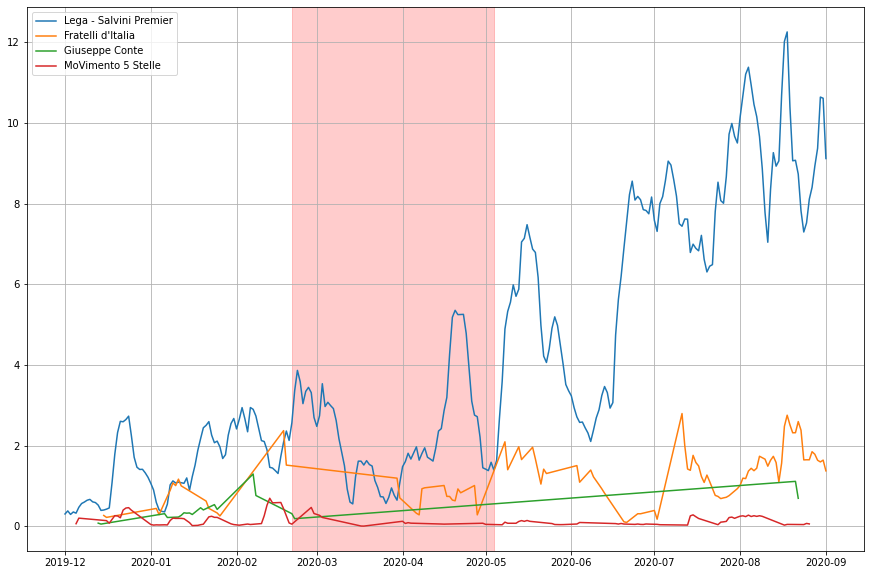

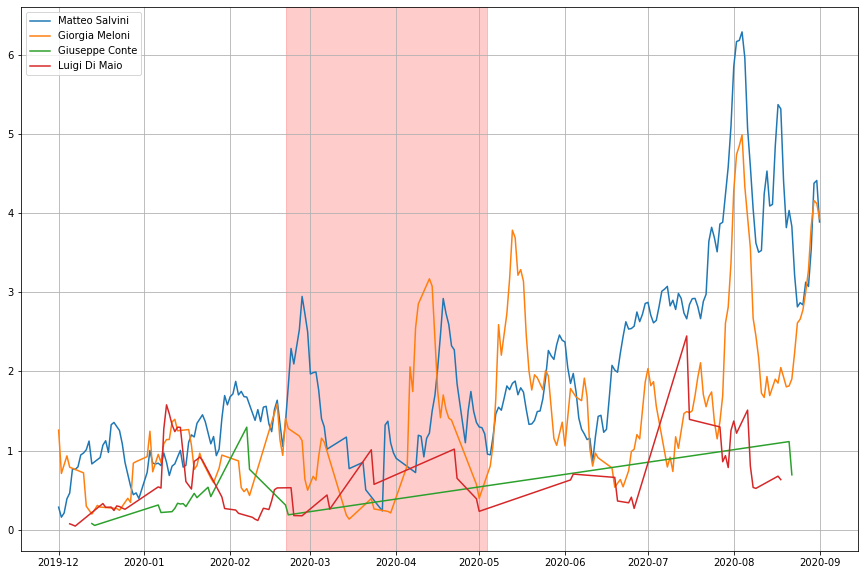

In [79]:
plot_ma_parties("7")
plot_ma_politicians("7")

### Experiments

In [ ]:
#df_time_series_simple

In [ ]:
df_time_series = df_time_series.set_index("date")

In [ ]:
df_time_series = df_time_series.sort_index()

In [ ]:
# groups_by_id = df_time_series.groupby(["id"])

In [ ]:
# Dict con chiave = date e valore => dict con chiave = nome_account e valore = lista di id_post pubblicati in quella data ()
# a quel punto parto dalla data minore, e da li costruisco finestre di 7 giorni. Per ogni giorno, l'engagement finale è dato
# dalla media rispetto a tutti i post a partire dall'inizio della finestra settimanale fino a quel giorno

## Create Date Map

In [ ]:
# now = df_time_series.iloc[0]["date"]
# print(now.year, now.month, now.day, now.hour, now.minute, now.second)

In [ ]:
groups_by_date = df_time_series_simple.groupby(["date"])

In [ ]:
groups_by_account = df_time_series_simple.groupby(["account"])

In [ ]:
accounts_list = [name.strip() for name, _ in groups_by_account]

In [ ]:
accounts_list

In [ ]:
example_date = datetime.strptime("2020-05-06", "%Y-%m-%d")

In [ ]:
j = 0
for n, dfdf in groups_by_date:
    if j == 0:
        example_df = dfdf.copy().reset_index()
    j += 1

In [ ]:
example_df

In [ ]:
example_df[example_df["account"] == "Lega - Salvini Premier"]["id"]

In [ ]:
for date_, g_df in groups_by_date:
    # print(type(date_))
    map_account_ids = {}
    for acc in accounts_list:
        map_account_ids[acc] = list(g_df[g_df["account"] == acc]["id"].values)
    date_map[date_] = map_account_ids

In [ ]:
i = 0
for d, map_ in date_map.items():
    if i == 0:
        print(d)
        pprint(map_)
    i += 1

In [ ]:
print_things(df_time_series_simple, "date")

In [ ]:
i = 0
for name, df in groups_by_id:
    if i == 0:
        if len(df[df["date"] < datetime(2020, 5, 1)]) > 1:
            i += 1
            print_things(df)
            print(min(df["date"]))
            print(max(df["date"]))

In [ ]:
with open(DATA_PATH + "politician_party_map.json") as json_file:
    politicians_party_map = json.load(json_file)

with open(DATA_PATH + "keywords_month.json") as json_file:
    keywords_month_map = json.load(json_file)

with open(DATA_PATH + "risk_keywords_month.json") as json_file:
    risk_keywords_month_map = json.load(json_file)

In [ ]:
for type_page in TYPE_PAGE_LIST:
    for type_social in TYPE_SOCIAL_LIST:
        for country_page in COUNTRY_PAGE_LIST:
            name_df = "_".join((type_page, type_social, country_page))
            df_map[name_df] = pd.read_csv(DATA_PATH + name_df + ".csv", header=0,)
            df_map[name_df]["Created"] = df_map[name_df]["Created"].apply(
                lambda x: parser.parse(x)
            )
            if type_social == "instagram":
                df_map[name_df]["Description"] = df_map[name_df]["Description"].fillna(
                    value=""
                )
            else:
                df_map[name_df]["Message"] = df_map[name_df]["Message"].fillna(value="")

In [ ]:
# df_map["politicians_facebook_italy"].head()

### Create DFs Map per Month

In [ ]:
for name_df, df in df_map.items():
    df_months_map[list(MONTHS_2019.keys())[0]][name_df] = df_map[name_df][
        (df_map[name_df]["Created"] >= "2019-12-01")
        & (df_map[name_df]["Created"] < "2020-01-01")
    ].copy()

for name_df, df in df_map.items():
    for month in MONTHS_2020.keys():
        df_months_map[month][name_df] = df_map[name_df][
            (df_map[name_df]["Created"] >= "2020-{}-01".format(MONTHS_2020[month]))
            & (df_map[name_df]["Created"] < "2020-{}-01".format(MONTHS_2020[month] + 1))
        ].copy()

In [ ]:
del df_map
gc.collect()

### Cleaning functions

In [ ]:
all_stopwords = sp.Defaults.stop_words
with open("stopwords_italian.json") as json_file:
    italian_stopwords = json.load(json_file)
all_stopwords |= set(italian_stopwords["stopwords"])

In [ ]:
def remove_emoji(text):
    return emoji.get_emoji_regexp().sub(u"", text)

In [ ]:
def clean_text(text):
    text = remove_emoji(text)
    # text = unidecode.unidecode(text)
    text = text.lower()
    text = text.strip()
    text = re.sub("#\S+:", "", text)
    text = re.sub("# \S+ :", "", text)
    text = re.sub("#\S+ :", "", text)
    text = re.sub("# \S+:", "", text)
    text = re.sub("#\S+", "", text)
    text = re.sub("legaonline.it\S+", "", text)
    text = re.sub("[,\.!?#]", "", text)
    text = re.sub("\s+", " ", text)
    text = (
        text.replace("http", "")
        .replace("www", "")
        .replace("shortener", "")
        .replace("ref", "")
        .replace("matteo salvini", "salvini")
        .replace("user", "")
        .replace("legaonline.it/iostoconsalvini", "")
    )
    text = re.sub("\s+", " ", text)
    # stop_words = set(stopwords.words("italian"))
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]

    res = " ".join(tokens_without_sw)
    return res

### Create map divided by couple politician + party and by month

In [ ]:
for month, df_map_month in df_months_map.items():
    for df_name, df_data in df_map_month.items():
        for pol, party in politicians_party_map.items():
            if len(party) > 0:
                complete_name = (
                    pol.lower().replace(" - ", " ").replace(" ", "_")
                    + "__"
                    + party.lower().replace(" - ", " ").replace(" ", "_")
                )
                df_specific_party_map[month][complete_name] = df_data.loc[
                    df_data["Page Name"].isin([pol, party])
                ].copy()
            else:
                complete_name = pol.lower().replace(" - ", " ").replace(" ", "_")
                df_specific_party_map[month][complete_name] = df_data.loc[
                    df_data["Page Name"].isin([pol])
                ].copy()
            df_specific_party_map[month][complete_name][
                "Message"
            ] = df_specific_party_map[month][complete_name]["Message"].apply(
                lambda x: clean_text(x)
            )
            df_specific_party_map[month][complete_name] = df_specific_party_map[month][
                complete_name
            ].reset_index()

In [ ]:
gc.collect()

## PLOT OF: Frequency of migration related posts per politician + party (together as one) throughout time 

In [ ]:
def avg_engagement(df_):
    engagements = []
    interactions_list = []
    for index, row in df_.iterrows():
        followers = row["Likes at Posting"]
        interactions = (
            row["Likes"]
            + row["Comments"]
            + row["Shares"]
            + row["Love"]
            + row["Wow"]
            + row["Haha"]
            + row["Sad"]
            + row["Angry"]
            + row["Care"]
        )
        # print(row)
        # print(followers)
        # print(interactions)
        engagements.append((interactions / followers) * 100)
        interactions_list.append(interactions)
        mean_engagement = sum(engagements) / len(engagements)
        mean_interactions = sum(interactions_list) / len(interactions_list)
    return round(mean_engagement, 2), round(mean_interactions, 2)

In [ ]:
for month, df_map_month in df_specific_party_map.items():
    lists_months_map[month] = {
        "page_names": [],
        "freq": [],
        "avg_engagement": [],
        "avg_interactions": [],
    }
    for df_name, df_data in df_map_month.items():
        words = "|".join(w for w in keywords_month_map[month])
        migration_posts = (
            df_data[df_data["Message"].str.contains(words)].copy().reset_index()
        )
        freq = len(migration_posts)
        # print(month,df_name,freq)
        if freq > 0:
            mean_engagement, mean_interactions = avg_engagement(migration_posts)
        else:
            mean_engagement = 0
            mean_interactions = 0
        df_pol_party_frequency_migration_map[month][df_name] = {
            "freq": freq,
            "avg_engagement": mean_engagement,
            "avg_interactions": mean_interactions,
        }
        lists_months_map[month]["page_names"].append(df_name)
        lists_months_map[month]["freq"].append(freq)
        lists_months_map[month]["avg_engagement"].append(mean_engagement)
        lists_months_map[month]["avg_interactions"].append(mean_interactions)

In [ ]:
print(df_pol_party_frequency_migration_map["mar"])
print(df_pol_party_frequency_migration_map["dec"])

In [ ]:
# Normalization parameters
normalize_min = 0.1
normalize_max = 1
for month, lists_map in lists_months_map.items():
    pages_names = lists_map["page_names"]
    engagements = lists_map["avg_engagement"]
    freq = lists_map["freq"]
    mean_interactions = lists_map["avg_interactions"]
    # Normalize
    freq = preprocessing.minmax_scale(
        freq, feature_range=(normalize_min, normalize_max)
    )
    engagements = preprocessing.minmax_scale(
        engagements, feature_range=(normalize_min, normalize_max)
    )
    mean_interactions = preprocessing.minmax_scale(
        mean_interactions, feature_range=(normalize_min, normalize_max)
    )

    df = pd.DataFrame(
        {
            "avg engagement": engagements,
            "posts containing migration keywords": freq,
            "avg interactions": mean_interactions,
        },
        index=[p.replace("__", " + ").replace("_", " ") for p in pages_names],
    )
    if len(df) > 0:
        ax = df.sort_values(
            "posts containing migration keywords", ascending=False
        ).plot(
            kind="bar",
            title="Frequency of migration related posts per politician + party per month - {}".format(
                month
            ),
            rot=90,
        )
        figures[month].append(ax)

### Generate PDFs of migration post by month

In [ ]:
for month, plots in figures.items():
    if month == "dec":
        name_file = OUTPUT_PATH + "frequency_migration_by_month/2019_{}.pdf".format(
            month
        )
    else:
        name_file = OUTPUT_PATH + "frequency_migration_by_month/2020_{}.pdf".format(
            month
        )
    pdf = matplotlib.backends.backend_pdf.PdfPages(name_file)
    for fig in plots:  ## will open an empty extra figure :(
        fig = fig.get_figure()
        # print(type(fig))
        pdf.savefig(fig, bbox_inches="tight")
    pdf.close()

## PLOT OF: Risk and threat narrative (keyword list) frequency over time per politician + party

In [ ]:
risk_words = "|".join(w for w in risk_keywords_month_map["risk_words"])
for month, df_map_month in df_specific_party_map.items():
    risk_lists_months_map[month] = {
        "page_names": [],
        "freq": [],
        "avg_engagement": [],
        "avg_interactions": [],
    }
    for df_name, df_data in df_map_month.items():
        risk_posts = (
            df_data[df_data["Message"].str.contains(risk_words)].copy().reset_index()
        )
        freq = len(risk_posts)
        # print(month,df_name,freq)
        if freq > 0:
            mean_engagement, mean_interactions = avg_engagement(risk_posts)
        else:
            mean_engagement = 0
            mean_interactions = 0
        df_pol_party_frequency_risk_map[month][df_name] = {
            "freq": freq,
            "avg_engagement": mean_engagement,
            "avg_interactions": mean_interactions,
        }
        risk_lists_months_map[month]["page_names"].append(df_name)
        risk_lists_months_map[month]["freq"].append(freq)
        risk_lists_months_map[month]["avg_engagement"].append(mean_engagement)
        risk_lists_months_map[month]["avg_interactions"].append(mean_interactions)

In [ ]:
# Normalization parameters
normalize_min = 0.1
normalize_max = 1
for month, lists_map in risk_lists_months_map.items():
    pages_names = lists_map["page_names"]
    engagements = lists_map["avg_engagement"]
    freq = lists_map["freq"]
    mean_interactions = lists_map["avg_interactions"]
    # Normalize
    freq = preprocessing.minmax_scale(
        freq, feature_range=(normalize_min, normalize_max)
    )
    engagements = preprocessing.minmax_scale(
        engagements, feature_range=(normalize_min, normalize_max)
    )
    mean_interactions = preprocessing.minmax_scale(
        mean_interactions, feature_range=(normalize_min, normalize_max)
    )

    df = pd.DataFrame(
        {
            "avg engagement": engagements,
            "posts containing risk keywords": freq,
            "avg interactions": mean_interactions,
        },
        index=[p.replace("__", " + ").replace("_", " ") for p in pages_names],
    )
    if len(df) > 0:
        ax = df.sort_values("posts containing risk keywords", ascending=False).plot(
            kind="bar",
            title="Frequency of risk related posts per politician + party per month - {}".format(
                month
            ),
            rot=90,
        )
        risk_figures[month].append(ax)

### Generate PDFs of risk post by month

In [ ]:
for month, plots in risk_figures.items():
    if month == "dec":
        name_file = OUTPUT_PATH + "frequency_risk_by_month/2019_{}.pdf".format(month)
    else:
        name_file = OUTPUT_PATH + "frequency_risk_by_month/2020_{}.pdf".format(month)
    pdf = matplotlib.backends.backend_pdf.PdfPages(name_file)
    for fig in plots:  ## will open an empty extra figure :(
        fig = fig.get_figure()
        # print(type(fig))
        pdf.savefig(fig, bbox_inches="tight")
    pdf.close()

## PLOT OF -using only the top ten (engagement) posts from Italian politicians on fb and Instagram as a corpus/subset of data-:  risk and threat narrative frequency in the TOP TEN (most liked/shared etc.) posts, by politicians

In [ ]:
def get_best_posts(df, social_type):
    if social_type == "instagram":
        df["interactions"] = df["Likes"] + df["Comments"]
        df = df.sort_values(
            by=["interactions", "Overperforming Score"], ascending=False
        ).iloc[0:10]
    else:
        df["interactions"] = (
            df["Likes"]
            + df["Comments"]
            + df["Shares"]
            + df["Love"]
            + df["Haha"]
            + df["Wow"]
            + df["Sad"]
            + df["Care"]
            + df["Angry"]
        )
        df = df.sort_values(
            by=["interactions", "Overperforming Score"], ascending=False
        ).iloc[0:10]
    return df

In [ ]:
for month, df_map_month in df_specific_party_map.items():
    for df_name, df_data in df_map_month.items():
        # social_type = df_name.split("_")[1]
        social_type = "facebook"
        df = get_best_posts(df_data.copy(), social_type)
        top_posts_map[month][df_name] = df.reset_index().drop(
            columns=["level_0", "index"]
        )

In [ ]:
gc.collect()

In [ ]:
risk_words = "|".join(w for w in risk_keywords_month_map["risk_words"])
for month, df_map_month in top_posts_map.items():
    risk_top_lists_months_map[month] = {
        "page_names": [],
        "freq": [],
        "avg_engagement": [],
        "avg_interactions": [],
    }
    for df_name, df_data in df_map_month.items():
        risk_top_posts = (
            df_data[df_data["Message"].str.contains(risk_words)].copy().reset_index()
        )
        freq = len(risk_top_posts)
        # print(month, df_name, freq)
        if freq > 0:
            mean_engagement, mean_interactions = avg_engagement(risk_top_posts)
        else:
            mean_engagement = 0
            mean_interactions = 0
        df_pol_party_top_risk_map[month][df_name] = {
            "freq": freq,
            "avg_engagement": mean_engagement,
            "avg_interactions": mean_interactions,
        }
        risk_top_lists_months_map[month]["page_names"].append(df_name)
        risk_top_lists_months_map[month]["freq"].append(freq)
        risk_top_lists_months_map[month]["avg_engagement"].append(mean_engagement)
        risk_top_lists_months_map[month]["avg_interactions"].append(mean_interactions)

In [ ]:
# Normalization parameters
normalize_min = 0.1
normalize_max = 1
for month, lists_map in risk_top_lists_months_map.items():
    pages_names = lists_map["page_names"]
    engagements = lists_map["avg_engagement"]
    freq = lists_map["freq"]
    mean_interactions = lists_map["avg_interactions"]
    # Normalize
    freq = preprocessing.minmax_scale(
        freq, feature_range=(normalize_min, normalize_max)
    )
    engagements = preprocessing.minmax_scale(
        engagements, feature_range=(normalize_min, normalize_max)
    )
    mean_interactions = preprocessing.minmax_scale(
        mean_interactions, feature_range=(normalize_min, normalize_max)
    )

    df = pd.DataFrame(
        {
            "avg engagement": engagements,
            "posts containing risk keywords": freq,
            "avg interactions": mean_interactions,
        },
        index=[p.replace("__", " + ").replace("_", " ") for p in pages_names],
    )
    if len(df) > 0:
        ax = df.sort_values("posts containing risk keywords", ascending=False).plot(
            kind="bar",
            title="Frequency of risk related posts (among top posts) per politician + party per month - {}".format(
                month
            ),
            rot=90,
        )
        risk_top_figures[month].append(ax)

### Generate PDFs of risk post by month

In [ ]:
for month, plots in risk_top_figures.items():
    if month == "dec":
        name_file = OUTPUT_PATH + "frequency_risk_topten/2019_{}.pdf".format(month)
    else:
        name_file = OUTPUT_PATH + "frequency_risk_topten/2020_{}.pdf".format(month)
    pdf = matplotlib.backends.backend_pdf.PdfPages(name_file)
    for fig in plots:  ## will open an empty extra figure :(
        fig = fig.get_figure()
        # print(type(fig))
        pdf.savefig(fig, bbox_inches="tight")
    pdf.close()